# Turtle Trading Strategy

## Reference:
- 量化课堂--海龟策略.https://www.joinquant.com/view/community/detail/b061c8738b509ec318c03e7af040bb9b
- Debug: Local variable referenced before assignment: The UnboundLocalError in Python. https://blog.arrowhitech.com/local-variable-referenced-before-assignment/
- Python 面向对象编程 OOP--02--类中的单下划线和双下划线 5 种情况。https://blog.csdn.net/u010701274/article/details/122317489
- Numpy中stack()，hstack()，vstack()函数详解。https://blog.csdn.net/csdn15698845876/article/details/73380803
- How to Calculate Volatility as Average True Range (ATR) with Python DataFrames and NumPy.https://www.learnpythonwithrune.org/how-to-calculate-volatility-as-average-true-range-atr-with-python-dataframes-and-numpy/
- prod()与cumprod()区别cumsum().https://blog.csdn.net/The_Time_Runner/article/details/88744300


## Explaination
- Turtle trading strategy is a trend follower which benefits from sustained momentum.
- It is a mature and completed trading system.

## Trading Logic
### 1. Trading Market Rule
- Trade in high liquidity and volatility markets
- Usually trade with commodities, energy, Chinese A shares, metal, Cryptocurrency. 

### 2. Position Sizing Rule
- True Range ($TR$)
  - Formula: $True \space Range=Maximum(H-L, High-PDC, PDC-Low)$
  - Notion:
    - $H$: current high
    - $L$: current low
    - $PDC$: previous day's closing price
- N
  - Formula: $N=\frac{PDC*[-n+1:]+TR}{n}$
  - Normally, we set $n=20$
  - For simplify calculation, we set $N≈ATR(n)=MA(TrueRange, n)$
- Dollar Volatility
  - Formula: $DV=N*Dollars \space per \space Point$
- Unit
  - Formula: $Unit=\frac{1\% * Account}{Market \space DV}$

### 3. Entry Rule
- Use the theory from Donchian Channel to capture momentum, market volatility, and trading signals.
- Divide cash into two parts. One is used in System1(short term system), another is used in System2(long term system).
- **System1**:
  - if price > 20-day high→Buy 1 Unit
  - Position Adding: if current price is larger than last trading price by $0.5N$ under long position→Buy 1 Unit
  - Position Reduction: if current price is lower than last trading price by $0.5N$ under short position→Sell 1 Unit
  - if price < 20-day low→Sell 1 Unit
- **System2**:
  - if price > 55-day high→Buy 1 Unit
  - Position Adding: if current price is larger than last trading price by $0.5N$ under long position→Buy 1 Unit
  - Position Reduction: if current price is lower than last trading price by $0.5N$ under short position→Sell 1 Unit
  - if price < 55-day low→Sell 1 Unit

### 4. Stop-Loss Rule
- If the current price is lower than last trading price by $2N$→Sell all
  - No trade will incur if risk > 20%

### 5. Take Profit Rule
- System1:
  - If price < 10-day low for long position→Sell all
  - If price > 10-day high for short position→Sell all
- System2:
  - If price < 20-day low for long position→Sell all
  - If price > 20-day high for short position→Sell all



In [38]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install pyfolio
import pyfolio as pf
from copy import deepcopy, copy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
# get the benchmark trading prices
SP500=yf.download('^GSPC','2000-01-01','2023-04-30', progress=False)[['Open','High','Low','Close','Adj Close']]

In [72]:
#calculate returns
SP500['returns']=SP500['Adj Close'].pct_change().dropna()
SP500['cum_returns']=(1+SP500['returns']).cumprod()

In [41]:
def calculateTR(high, low, close):
  '''
  Calculate True Range
  '''
  return np.max(np.abs([high-low, close-low, low-close]))

In [51]:
class TurtleTradingSystem:
  def __init__(self, 
               tickers, 
               init_account_size=100000, 
               risk_level=2, 
               r_max=0.02,
               sys1_entry=20, 
               sys1_exit=10, 
               sys2_entry=55, 
               sys2_exit=20,
               atr_periods=20, 
               sys1_allocation=0.5, 
               risk_reduction_rate=0.1,
               risk_reduction_level=0.2, 
               unit_limit=5, 
               pyramid_units=1, 
               start='2000-01-01', 
               end='2023-04-30', 
               shorts=True):
    '''
    tickers: list of stock we select to trade;
    init_account: the initialize trading cash amount;
    risk_level: stop loss barrier;
    risk_max: max percentage of account that a trade can take a risk;
    system1_entry: define the number of breakout days for system1 to generate a buy signal;
    system1_exit: define the number of breakout days for system1 to generate a sell signal;
    system2_entry: define the number of breakout days for system2 to generate a buy signal;
    system2_exit: define the number of breakout days for system2 to generate a sell signal;
    ATR_periods: define the number of days for SMA calculation;
    system1_allocation: capital allocation between system1 and system2;
    risk_reduction_rate: the amount of loss before reducing the trading size;
    risk_reduction_level: each increment in risk the system reduces as it loses capital below its initial size;
    shorts: a boolean value to allow short or not;
    '''
    self.tickers = tickers
    self.init_account_size = init_account_size
    self.cash = init_account_size
    self.portfolio_value = init_account_size
    self.risk_level = risk_level
    self.r_max = r_max
    self.sys1_entry = sys1_entry
    self.sys1_exit = sys1_exit
    self.sys2_entry = sys2_entry
    self.sys2_exit = sys2_exit
    self.sys1_allocation = sys1_allocation
    self.sys2_allocation = 1 - sys1_allocation
    self.start = start
    self.end = end
    self.ATR_periods = atr_periods
    self.shorts = shorts
    self.last_s1_win = {t: False for t in self.tickers}
    self.unit_limit = unit_limit
    self.risk_reduction_level = risk_reduction_level
    self.risk_reduction_rate = risk_reduction_rate
    self.pyramid_units = pyramid_units
    self.sys_list = ['S1', 'S2']

    self._prep_data()

  def _prep_data(self):
    self.data = self._get_data()
    self._calculate_breakouts()
    self._calculate_N()

  def _get_data(self):
    # Gets data for all tickers from YFinance
    yfObj = yf.Tickers(self.tickers)
    df = yfObj.history(start=self.start, end=self.end)
    df.drop(['Open', 'Dividends', 'Stock Splits', 'Volume'], inplace=True, axis=1)
    df.ffill(inplace=True)
    return df.swaplevel(axis=1)

  def _calculate_breakouts(self):
    # Gets breakouts for all tickers
    for t in self.tickers:
      # Breakouts for enter long position (EL), exit long (ExL)
      # enter short (ES), exit short (ExS)
      self.data[t, 'S1_EL'] = self.data[t]['Close'].rolling(self.sys1_entry).max()
      self.data[t, 'S1_ExL'] = self.data[t]['Close'].rolling(self.sys1_exit).min()
      self.data[t, 'S2_EL'] = self.data[t]['Close'].rolling(self.sys2_entry).max()
      self.data[t, 'S2_ExL'] = self.data[t]['Close'].rolling(self.sys2_exit).min()

      if self.shorts:
        self.data[t, 'S1_ES'] = self.data[t]['Close'].rolling(self.sys1_entry).min()
        self.data[t, 'S1_ExS'] = self.data[t]['Close'].rolling(self.sys1_exit).max()
        self.data[t, 'S2_ES'] = self.data[t]['Close'].rolling(self.sys2_entry).min()
        self.data[t, 'S2_ExS'] = self.data[t]['Close'].rolling(self.sys2_exit).max()

  def _calculate_N(self):
    # Calculates N for all tickers
    for t in self.tickers:
      tr = self.data[t].apply(
          lambda x: calculateTR(x['High'], x['Low'], x['Close']), axis=1)
      self.data[t, 'N'] = tr.rolling(self.ATR_periods).mean()

  def _check_cash_balance(self, shares, price):
    # Checks to see if we have enough cash to make purchase.
    # If not, resizes position to lowest feasible level
    if self.cash <= shares * price:
      shares = np.floor(self.cash / price)
    return shares

  def _adjust_risk_units(self, units):
    capital_loss = 1 - self.portfolio_value / self.init_account_size
    if capital_loss > self.risk_reduction_level:
      scale = np.floor(capital_loss / self.risk_reduction_level)
      units *= (1 - scale * self.risk_reduction_rate)
    return units

  def _calc_portfolio_value(self, portfolio):
    pv = sum([v1['value'] for v0 in portfolio.values() if type(v0) is dict 
              for k1, v1 in v0.items() if v1 is not None])
    pv += self.cash
    if np.isnan(pv):
      raise ValueError(f"PV = {pv}\n{portfolio}")
    return pv

  def _get_units(self, system):
    sys_all = self.sys1_allocation if system == 1 else self.sys2_allocation
    dollar_units = self.r_max * self.portfolio_value * sys_all
    dollar_units = self._adjust_risk_units(dollar_units)
    return dollar_units

  def _size_position(self, data, dollar_units):
    shares = np.floor(dollar_units / (
        self.risk_level * data['N'] * data['Close']))
    return shares

  def _run_system(self, ticker, data, position, system=1):
    S = system # System number
    price = data['Close']
    if np.isnan(price):
      # Return current position if there is missing data
      return position
    N = data['N']
    dollar_units = self._get_units(S)
    shares =  0
    if position is None:
      if price == data[f'S{S}_EL']: 
        if S == 1 and self.last_s1_win[ticker]:
          self.last_s1_win[ticker] = False
          return None
        shares = self._size_position(data, dollar_units)
        stop_price = price - self.risk_level * N
        long = True
      elif self.shorts:
        if price == data[f'S{S}_ES']: 
          if S == 1 and self.last_s1_win[ticker]:
            self.last_s1_win[ticker] = False
            return None
          shares = self._size_position(data, dollar_units)
          stop_price = price + self.risk_level * N
          long = False
      else:
        return None
      if shares == 0:
        return None
      # Ensure we have enough cash to trade
      shares = self._check_cash_balance(shares, price)
      value = price * shares

      self.cash -= value
      position = {'units': 1,
                  'shares': shares,
                  'entry_price': price,
                  'stop_price': stop_price,
                  'entry_N': N,
                  'value': value,
                  'long': long}
      if np.isnan(self.cash) or self.cash < 0:
        raise ValueError(f"Cash Error\n{S}-{ticker}\n{data}\n{position}")

    else:
      if position['long']:
        # Check exit existing long position
        if price == data[f'S{S}_ExL'] or price <= position['stop_price']:
          self.cash += position['shares'] * price
          if price >= position['entry_price']:
            self.last_s1_win[ticker] = True
          else:
            self.last_s1_win[ticker] = False
          position = None
        # Check the further addition adj exists or not
        elif position['units'] < self.unit_limit:
          if price >= position['entry_price'] + position['entry_N']:
            shares = self._size_position(data, dollar_units)
            shares = self._check_cash_balance(shares, price)
            self.cash -= shares * price
            stop_price = price - self.risk_level * N
            avg_price = (position['entry_price'] * position['shares'] + shares * price) / (position['shares'] + shares)
            position['entry_price'] = avg_price
            position['shares'] += shares
            position['stop_price'] = stop_price
            position['units'] += 1
      else:
        # Check exit existing short position
        if price == data[f'S{S}_ExS'] or price >= position['stop_price']:
          self.cash += position['shares'] * price
          if S == 1:
            if price <= position['entry_price']:
              self.last_s1_win[ticker] = True
            else:
              self.last_s1_win[ticker] = False
          position = None
        # Check the further reduction adj exist or not
        elif position['units'] < self.unit_limit:
          if price <= position['entry_price'] - position['entry_N']:
            shares = self._size_position(data, dollar_units)
            shares = self._check_cash_balance(shares, price)
            self.cash -= shares * price
            stop_price = price + self.risk_level * N
            avg_price = (position['entry_price'] * position['shares'] + shares * price) / (position['shares'] + shares)
            position['entry_price'] = avg_price
            position['shares'] += shares
            position['stop_price'] = stop_price
            position['units'] += 1

      if position is not None:
        # Update value at each time step
        position['value'] = position['shares'] * price
        
    return position

  def run(self):
    # Runs backtesting
    self.portfolio = {}
    position = {s: 
                  {t: None for t in self.tickers}
                for s in self.sys_list}

    for i, (ts, row) in enumerate(self.data.iterrows()):
      for t in self.tickers:
        for s, system in enumerate(self.sys_list):
          position[system][t] = self._run_system(t, row[t], position[system][t])
      self.portfolio[i] = deepcopy(position)
      self.portfolio[i]['date'] = ts
      self.portfolio[i]['cash'] = copy(self.cash)
      self.portfolio_value = self._calc_portfolio_value(self.portfolio[i])

  def get_portfolio_values(self):
    vals = []
    for v in self.portfolio.values():
      portfolio_value = sum([v1['value'] for v0 in v.values() if type(v0) is dict 
              for k1, v1 in v0.items() if v1 is not None])
      portfolio_value += v['cash']
      vals.append(pv)
    return pd.Series(vals, index=self.data.index)

  def get_system_data_dict(self):
    sys_dict = {}
    cols = ['units', 'shares', 'entry_price', 'stop_price',
      'entry_N', 'value', 'long']
    X = np.empty(shape=(len(cols))) 
    X[:] = np.nan
    index = [v['date'] for v in self.portfolio.values()]
    for s in self.sys_list:
      for t in self.tickers:
        df = pd.DataFrame()
        for i, v in enumerate(self.portfolio.values()):
          d = v[s][t]
          if d is None:
            if i == 0:
              _array = X.copy()
            else:
              _array = np.vstack([_array, X]) #stack in vertical way orderly
          else:
            vals = np.array([float(d[i]) for i in cols])
            if i == 0:
              _array = vals.copy()
            else:
              _array = np.vstack([_array, vals])
        df = pd.DataFrame(_array, columns=cols, index=index)
        sys_dict[(s, t)] = df.copy()
    return sys_dict

  def get_transactions(self):
    ddict = self.get_system_data_dict()
    transactions = pd.DataFrame()
    for k, v in ddict.items():
      df = pd.concat([v, self.data[k[1]].copy()], axis=1)
      df.fillna(0, inplace=True)
      rets = df['Close'] / df['entry_price'].shift(1) -1
      trans = pd.DataFrame(rets[df['shares'].diff()<0], 
        columns=['Returns'])
      trans['System'] = k[0]
      trans['Ticker'] = k[1]
      trans['Long'] = df['long'].shift(1).loc[df['shares'].diff()<0]
      trans['Units'] = df['units'].shift(1).loc[df['shares'].diff()<0]
      trans['Entry_Price'] = df['entry_price'].shift(1).loc[
        df['shares'].diff()<0]
      trans['Sell_Price'] = df['Close'].loc[df['shares'].diff()<0]
      trans['Shares'] = df['shares'].shift(1).loc[df['shares'].diff()<0]
      trans.reset_index(inplace=True)
      trans.rename(columns={'index': 'Date'}, inplace=True)
      transactions = pd.concat([transactions, trans.copy()])

    transactions.reset_index(inplace=True)
    transactions.drop('index', axis=1, inplace=True)
    return transactions

In [69]:
tickers=['QQQ','TLT','GLD','XLE','XLI','XLB','XLF','XLRE','XLV','DIA','XLG','XLU','ITA','XLY','SOXX','XLP','IWM','KWEB','MDY','IVV']
trading = TurtleTradingSystem(tickers)
trading.run()

[*********************100%***********************]  20 of 20 completed


<ipython-input-51-754cbd5be09d>:216: RuntimeWarning: invalid value encountered in double_scalars
  avg_price = (position['entry_price'] * position['shares'] +
<ipython-input-51-754cbd5be09d>:193: RuntimeWarning: invalid value encountered in double_scalars
  avg_price = (position['entry_price'] * position['shares'] +


In [70]:
#get returns of portfolio after applying the turtle trading strategy
portfolio_values = trading.get_portfolio_values()
Algo_returns = portfolio_values.pct_change().dropna()
Algo_cum_rets = (1+Algo_returns).cumprod()

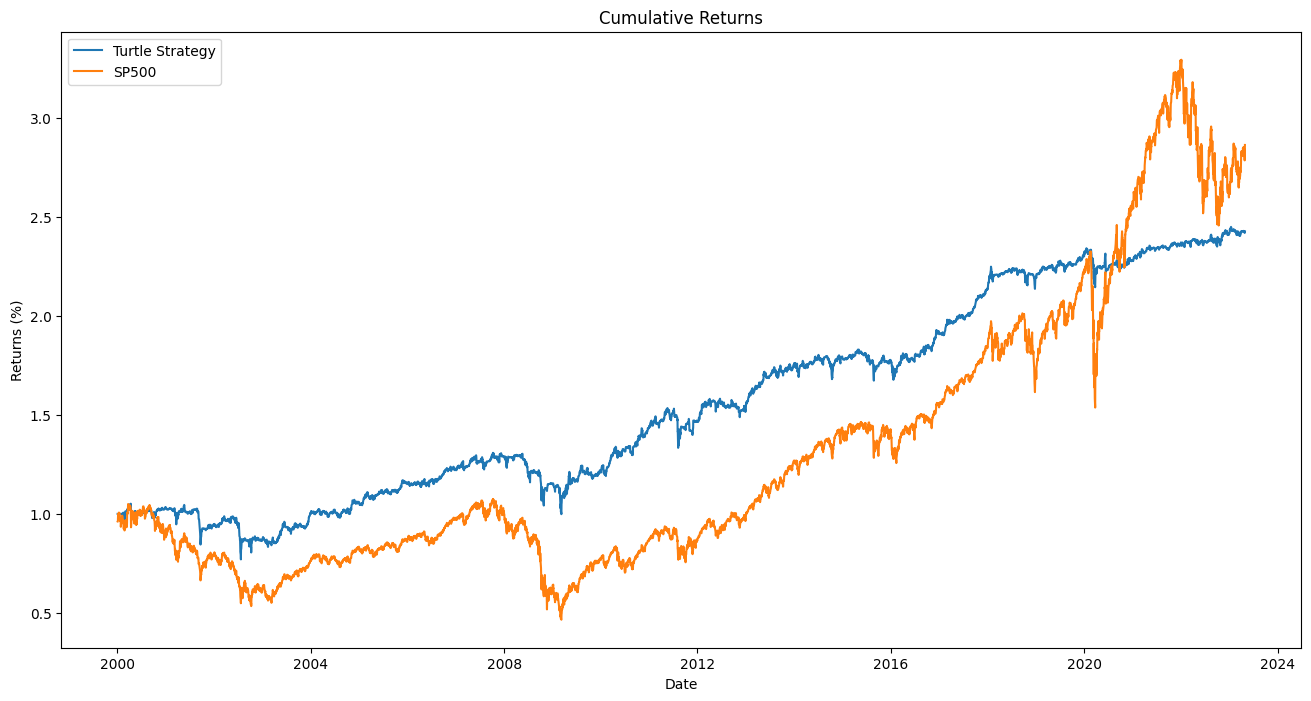

In [71]:
plt.figure(figsize=(16, 8))
plt.plot(Algo_cum_rets,label='Turtle Strategy')
plt.plot(SP500['cum_returns'], label='SP500')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Cumulative Returns')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2000-01-04
End date,2023-04-28
Total months,279
,Backtest
Annual return,3.883%
Cumulative returns,142.764%
Annual volatility,9.083%
Sharpe ratio,0.46
Calmar ratio,0.15
Stability,0.96
Max drawdown,-26.776%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,26.78,2000-04-12,2002-07-23,2004-11-11,1197
1,23.69,2007-10-09,2009-03-09,2010-04-05,650
2,13.10,2011-05-19,2011-08-08,2012-02-03,187
3,8.57,2015-04-27,2015-08-25,2016-09-02,355
4,8.41,2020-01-17,2020-03-23,2021-04-21,329


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this w

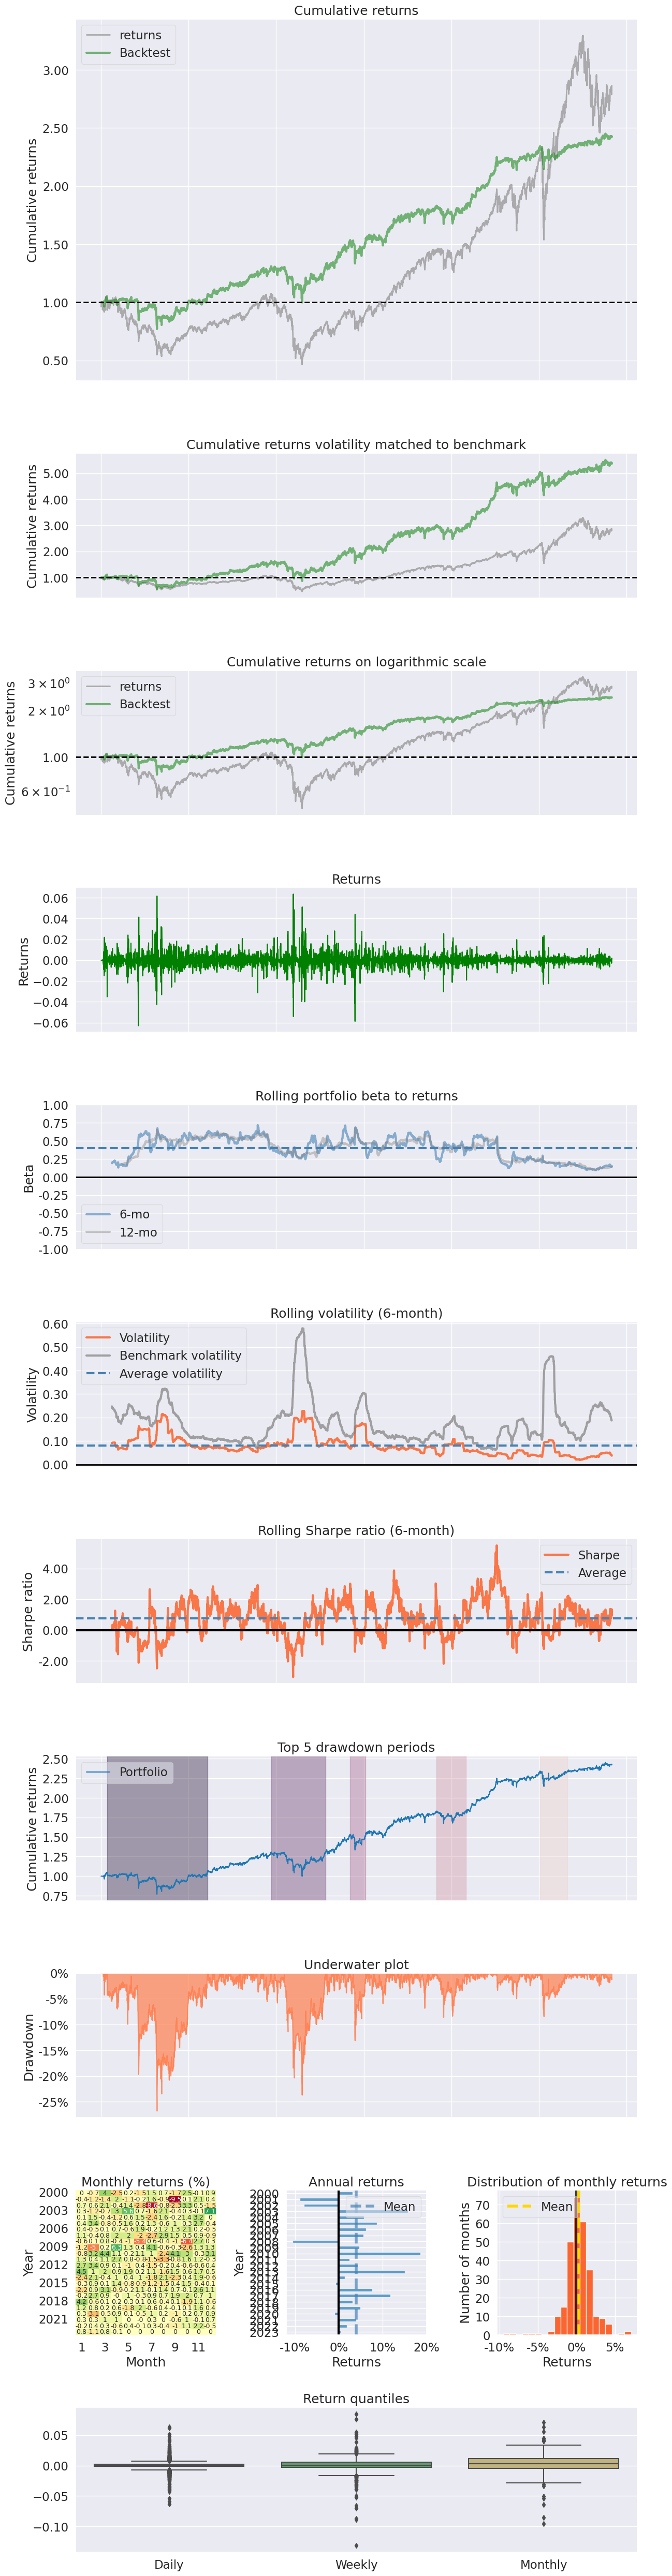

In [73]:
performance= pf.create_returns_tear_sheet(Algo_returns, benchmark_rets=SP500['returns'])